# PPXF

#In this code, we will analyze the spectra of extragalactic objects around **ESO325-G004**. These objects were observed with GMOS and represent potential targets of globular clusters (GC) or ultra-compact dwarf galaxies (UCD).
##Code used in the master's thesis of Weligton Nogueira Costa Júnior.

#Import ppxf and other libraries

In [ ]:
import glob
from os import path
from time import perf_counter as clock

import matplotlib.pyplot as plt
from astropy.io import fits
from scipy import ndimage
import numpy as np
from astropy.io import ascii
import os

from ppxf.ppxf import ppxf
import ppxf.ppxf_util as util


from scipy import signal
from numpy.polynomial import legendre




#Creat Class and functions


In [ ]:
class teste(object):
    def __init__(self, path_obj, file,path_masky, file2, FWHM_gal, high_redshift, z0, lam0, lam1):
        ppxf_dir = path.dirname(path.realpath(util.__file__))

        hdu = ascii.read(path_obj + '/' + file)

        #m = ascii.read(path_masky + '/' + file2)
        m = np.loadtxt(os.path.join(path_masky, file2))

        gal_lin = hdu['Flux']

        noise = hdu['Sigma']

        lamb = hdu['Lambda']

        mask = (lamb >= lam0) & (lamb <= lam1) #here we choose the range of lambda which we will use

        gal_lin = gal_lin[mask]

        noise = noise[mask]

        self.lamb = lamb[mask]

        pss = hdu['Lambda'][1] - hdu ['Lambda'][0] #Calculate the step of our spectra

        lamRange1 = self.lamb[0] + np.array([0.,pss*len(self.lamb)-1 ]) #the range what we use

        if high_redshift:           # Use these lines if your spectrum is at high-z
            lamRange1 /= 1 + z0     # Compute approximate restframe wavelength range
            FWHM_gal /= 1 + z0      # Adjust resolution in wavelength units
            self.z = 0              # As I de-redshifted the spectrum, the guess becomes z=0
            self.z0 = z0
        else:           # Use these lines if your spectrum is at low-z
            self.z = z0      # Ignore cosmological redshift for local galaxies
            self.z0 = 0      # Initial redshift estimate of the galaxy

        galaxy, self.ln_lam1, self.velscale = util.log_rebin(lamRange1, gal_lin) # For

        #self.noise = noise/np.median(galaxy)

        self.noise = noise/np.median(galaxy)  #normalizing noise by the original flux median

        noise_median = np.median(self.noise)

        noise_zero_ind = np.where(self.noise == 0)

        self.noise[noise_zero_ind] = noise_median

        self.galaxy = galaxy/np.median(galaxy) # normalizing the flux by median

        # Read the list of filenames from the E-Miles Single Stellar Population
        # library by Vazdekis (2016, MNRAS, 463, 3409) http://miles.iac.es/.
        # A subset of the library is included for this example with permission
        #
        vazdekis = glob.glob(ppxf_dir + '/miles_models/Eun1.30*.fits')
        FWHM_tem = 2.51     # Vazdekis+16 spectra have a constant resolution FWHM of 2.51A.
        self.velscale_ratio = 2  # adopts 2x higher spectral sampling for templates than for galaxy

        # Extract the wavelength range and logarithmically rebin one spectrum to a
        # velocity scale 2x smaller than the SAURON galaxy spectrum, to determine
        # the size needed for the array which will contain the template spectra.
        #
        hdu1 = fits.open(vazdekis[0])
        ssp = hdu1[0].data
        h2 = hdu1[0].header
        lam2 = h2['CRVAL1'] + h2['CDELT1']*np.arange(h2['NAXIS1'])

        # The E-Miles templates span a large wavelength range. To save some
        # computation time I truncate the spectra to a similar range as the galaxy.
        good_lam = (lam2 > lamRange1[0]/1.02) & (lam2 < lamRange1[1]*1.02)

        #ssp, lam2 = ssp[good_lam], lam2[good_lam]
        lamRange2 = [np.min(lam2), np.max(lam2)]
        sspNew, self.ln_lam2 = util.log_rebin(lamRange2, ssp, velscale=self.velscale/self.velscale_ratio)[:2]
        templates = np.empty((sspNew.size, len(vazdekis)))
        # Convolve the whole Vazdekis library of spectral templates
        # with the quadratic difference between the SAURON and the
        # Vazdekis instrumental resolution. Logarithmically rebin
        # and store each template as a column in the array TEMPLATES.

        # Quadratic sigma difference in pixels Vazdekis --> SAURON
        # The formula below is rigorously valid if the shapes of the
        # instrumental spectral profiles are well approximated by Gaussians.
        #
        FWHM_dif = np.sqrt(FWHM_gal**2 - FWHM_tem**2)
        sigma = FWHM_dif/2.355/h2['CDELT1']  # Sigma difference in pixels

        for j, file_ssp in enumerate(vazdekis):
            hdu1 = fits.open(file_ssp)
            ssp = hdu1[0].data

            ssp = ndimage.gaussian_filter1d(ssp, sigma)

            sspNew = util.log_rebin(lamRange2, ssp, velscale=self.velscale/self.velscale_ratio)[0]

            templates[:, j] = sspNew/np.median(sspNew[sspNew > 0])  # Normalizes templates
        self.templates = templates

        #self.goodPixels = util.determine_goodpixels(self.ln_lam1, lamRange2,self.z, width=800)



        #self.goodPixels = np.delete(self.goodPixels,np.s_[30:60])

        self.masky = np.ones_like(self.lamb).astype(bool)
        e1,e2 = np.loadtxt(path_masky + '/' + file2, unpack = True)
        if isinstance(e1,float):
            i,j = e1,e2
            indices = np.where((self.ln_lam1 >= np.log(i)) &\
                               (self.ln_lam1 <= np.log(j) ))

            #print(i,a,np.exp(self.ln_lam1[a]),j,b,np.exp(self.ln_lam1[b]))
            self.masky[indices] = False
        else:
            for i,j in zip (e1,e2):
                #print(i,j)
                #a = np.where(self.lamb == i)[0][0]
                #b = np.where(self.lamb == j)[0][0]
                indices = np.where((self.ln_lam1 >= np.log(i)) &\
                                   (self.ln_lam1 <= np.log(j) ))
                self.masky[indices] = False


        #print(len(ln_lam1))
        # Here the actual fit starts. The best fit is plotted on the screen.
        # Gas emission lines are excluded from the pPXF fit using the GOODPIXELS keyword.
        #
        self.c = 299792.458
        vel = self.c*np.log(1 + self.z0)   # eq.(8) of Cappellari (2017, MNRAS)
        self.start = [vel, 70]  # (km/s), starting guess for [V, sigma]


    #def masky(self):
    #    masky = np.ones_like(self.lamb).astype(bool)
    #    np.nanmean(self.gal_lin)

        self.vsyst = self.c*np.log(np.e**self.ln_lam2[0]/np.e**self.ln_lam1[0])




    def run_so_far_away(self, moments, degree, mdegree, plot):
        self.pp = ppxf(self.templates, self.galaxy, self.noise, self.velscale,
                  self.start,plot=plot,moments=moments,mask = self.masky, lam=np.exp(self.ln_lam1),
                  lam_temp=np.exp(self.ln_lam2),
                  degree= degree, mdegree = mdegree,velscale_ratio=self.velscale_ratio, global_search=False)

        print("Formal errors:")
        print("     dV      ")
        errors = self.pp.error*np.sqrt(self.pp.chi2)   # assume the fit is good
        print("".join("%8.2g" % f for f in errors))

        self.errors = errors
        sol = self.pp.sol


        # The updated best-fitting redshift is given by the following
        # lines (using equation 8 of Cappellari 2017, MNRAS)
        vcosm = self.c*np.log(1 + self.z)  # This is the initial redshift estimate
        vpec = self.pp.sol[0]          # This is the fitted residual velocity
        vtot = vcosm + vpec       # I add the two velocities before computing z
        print(f"Best-fitting redshift z = {np.exp(vtot/self.c) - 1:#.7f} "
            f"+/- {np.exp(vtot/self.c)*errors[0]/self.c:#.2g}")  # error propagation

      ##############################################################################
def bootstrap_residuals(model, resid, wild=True):
    """
    https://en.wikipedia.org/wiki/Bootstrapping_(statistics)#Resampling_residuals
    https://en.wikipedia.org/wiki/Bootstrapping_(statistics)#Wild_bootstrap

    Davidson & Flachaire (2008) eq.(12) gives the reccomended form
    of the wild bootrsapping probability used here.

    https://doi.org/10.1016/j.jeconom.2008.08.003

    :param spec: model (e.g. best fitting spectrum)
    :param res: residuals (best_fit - observed)
    :param wild: use wild bootsrap to allow for variable errors
    :return: new model with bootstrapped residuals

    """
    if wild:    # Wild Bootstrapping: generates -resid or resid with prob=1/2
        eps = resid*(2*np.random.randint(2, size=resid.size) - 1)
    else:       # Standard Bootstrapping: random selection with repetition
        eps = np.random.choice(resid, size=resid.size)

    return model + eps

# Test code

 Best Fit:       Vel     sigma
 comp.  0:     22832       152
chi2/DOF: 18.61; DOF: 1694; degree = 20; mdegree = 10
method = capfit; Jac calls: 7; Func calls: 103; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/150
Formal errors:
     dV      
      74 1.1e+02
Best-fitting redshift z = 0.0791345 +/- 0.00027


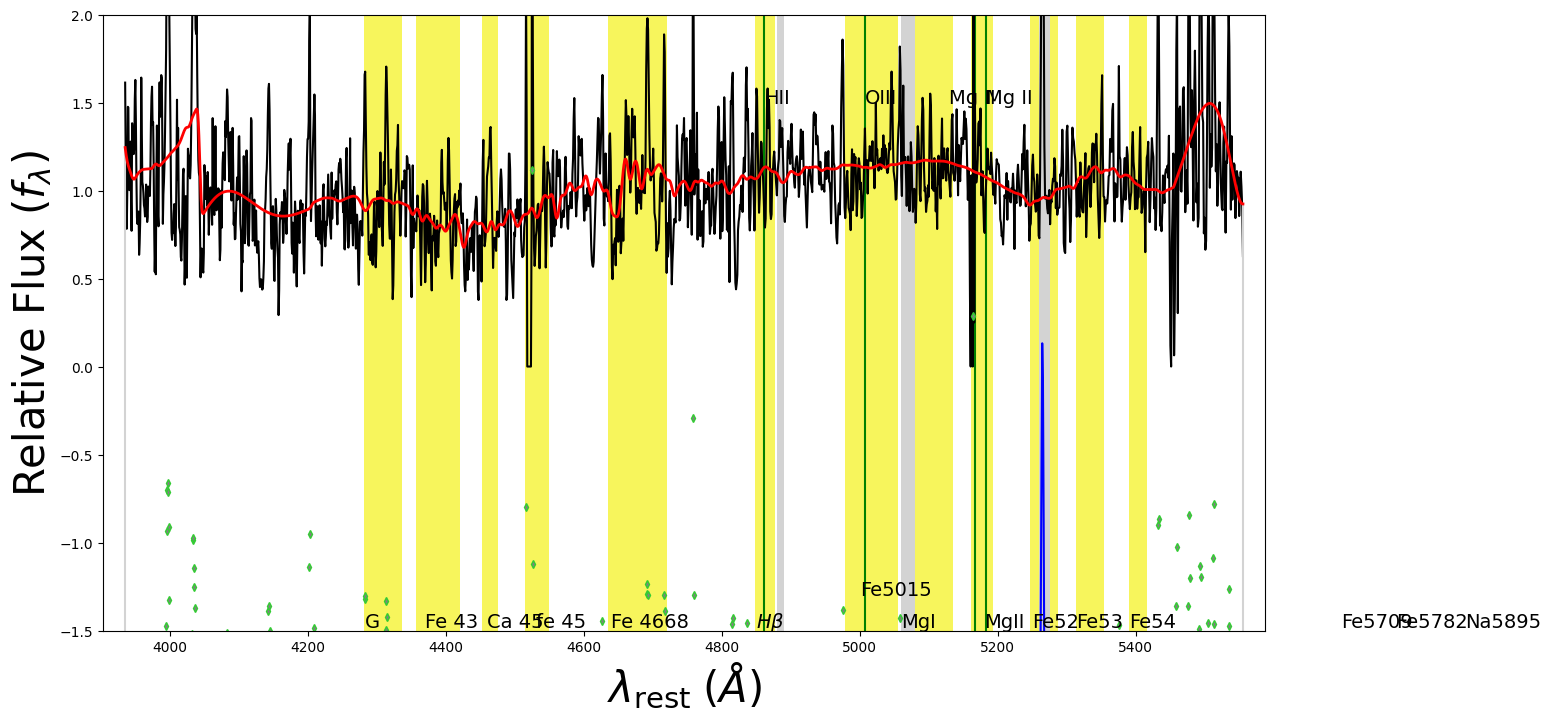

In [ ]:
plt.figure(figsize = (15,8))
Teste = teste(path_obj = '/home/junior/Mestrado/Spec/PPXF',
                    file = 'obj_18.txt', #randon object chose for user
                    path_masky ='/home/junior/Mestrado/Spec/PPXF/',
                    file2 = 'masky_01.txt' ,
                    FWHM_gal = 6,
                    high_redshift = True,
                    z0 = 0.08,
                    lam0 = 4250,
                    lam1 = 6000)
Teste.run_so_far_away(moments = 2,
                     degree = 20,
                     mdegree = 10,
                     plot = True)

In [ ]:
files = np.loadtxt('/home/junior/Mestrado/Spec/PPXF/files_obj.txt', dtype = str )
mask2 = np.loadtxt('/home/junior/Mestrado/Spec/PPXF/files_mask.txt',dtype = str )
id = np.loadtxt('/home/junior/Mestrado/Spec/PPXF/id.txt',dtype = int)
id

array([ 1,  2,  3,  5, 12, 14, 16, 17, 19, 22, 35, 38, 43, 52, 57])

#Loop using all the targets

In [ ]:
try:
    for  i,(name, name2,name3) in enumerate(zip(files,mask2,id)):


        Teste = teste(path_obj = '/home/junior/Mestrado/Spec/PPXF',
                      file = name,
                      path_masky ='/home/junior/Mestrado/Spec/PPXF/',
                      file2 = name2 ,
                      FWHM_gal = 6,
                      high_redshift = False,
                      z0 = 0.034,
                      lam0 = 4250,
                     lam1 = 6000)
        print(name)
        print(name2)

        fig = plt.gcf()
        fig.set_size_inches(30, 8)

        Teste.run_so_far_away(moments = 2,
                         degree = 20,
                         mdegree = 10,
                         plot = True)

        bestfit0 = Teste.pp.bestfit.copy()
        resid = Teste.galaxy - bestfit0
        start = Teste.pp.sol.copy()
        #Teste.pp.sol
        nrand = 500
        kinet_array = np.empty((nrand, Teste.pp.sol.size))
        for j in range(nrand):

            galaxy1 = bootstrap_residuals(bestfit0, resid)

            #t = clock()
            pp = ppxf(Teste.templates, galaxy1, Teste.noise, Teste.velscale,velscale_ratio = Teste.velscale_ratio, mask = Teste.masky,
                    start = start, moments=2, degree=10, mdegree=4, lam=np.exp(Teste.ln_lam1), lam_temp=np.exp(Teste.ln_lam2),
                    quiet=1)
            #print(f"{j + 1}/{nrand}: Elapsed time in pPXF: {clock() - t:.2f} s")

            kinet_array[j] = pp.sol

        tabela[i,0] = name3
        tabela[i,1] = Teste.pp.sol[0]
        tabela[i,2] = kinet_array[:,0].std()
        tabela[i,3] = Teste.pp.sol[1]
        tabela[i,4] = Teste.errors[1]
        tabela[i,5] = Teste.pp.chi2

        plt.savefig(f'./Final/obj_{name3}.png')
        #plt.show()
        plt.clf()
except:
    pass
np.savetxt(fname = './Final/plots_objs.txt',X=tabela,header= 'obj\t vel\t error(Vel)\t sigma\t erro(sigma)\t chi2')


obj_01.txt
masky_01.txt
 Best Fit:       Vel     sigma
 comp.  0:       123         2
chi2/DOF: 6.239; DOF: 1651; degree = 20; mdegree = 10
method = capfit; Jac calls: 9; Func calls: 125; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/150
Formal errors:
     dV      
      44 3.5e+03
Best-fitting redshift z = 0.0344245 +/- 0.00015
obj_02.txt
masky_02.txt
 Best Fit:       Vel     sigma
 comp.  0:       -94         1
chi2/DOF: 5.423; DOF: 1691; degree = 20; mdegree = 10
method = capfit; Jac calls: 6; Func calls: 87; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/150
Formal errors:
     dV      
     6.6 6.4e+02
Best-fitting redshift z = 0.0336768 +/- 2.3e-05
obj_03.txt
masky_03.txt
 Best Fit:       Vel     sigma
 comp.  0:        -0         1
chi2/DOF: 23.49; DOF: 1685; degree = 20; mdegree = 10
method = capfit; Jac calls: 7; Func calls: 97; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/150
Formal errors:
     dV      
     3.7 3.6e+02


<Figure size 3000x800 with 0 Axes>

In [ ]:
a